In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from mlflow.models import infer_signature

from Models.sklearn_model import SklearnModel
from preprocessing.preprocessing import PreProcessing
from utils.mlflow_utils import log_confusion_matrix


In [2]:
df = pd.read_csv(r"C:\Learn_AI\Model\Titanic_2\DataSet\titanic.csv")
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             30
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          125
Embarked         1
dtype: int64

In [4]:
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked']]

In [5]:
df['Age'].fillna(df['Age'].median() , inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0] , inplace =True)

In [6]:
df['Family_total'] = df['SibSp'] + df['Parch'] + 1
df.drop(['SibSp' , 'Parch' , 'Cabin'] , axis = 1 , inplace = True)

In [7]:
df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_total
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1


In [8]:
df.describe()

,Survived,Pclass,Age,Fare,Family_total
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.346154,2.423077,27.729679,28.109587,2.012821
std,0.477275,0.795459,13.150938,39.401047,1.614400
min,0.000000,1.000000,0.830000,6.750000,1.000000
25%,0.000000,2.000000,21.000000,8.003150,1.000000
50%,0.000000,3.000000,26.000000,14.454200,1.000000
75%,1.000000,3.000000,33.000000,30.371850,2.000000
max,1.000000,3.000000,71.000000,263.000000,8.000000


<Axes: xlabel='Survived', ylabel='Age'>

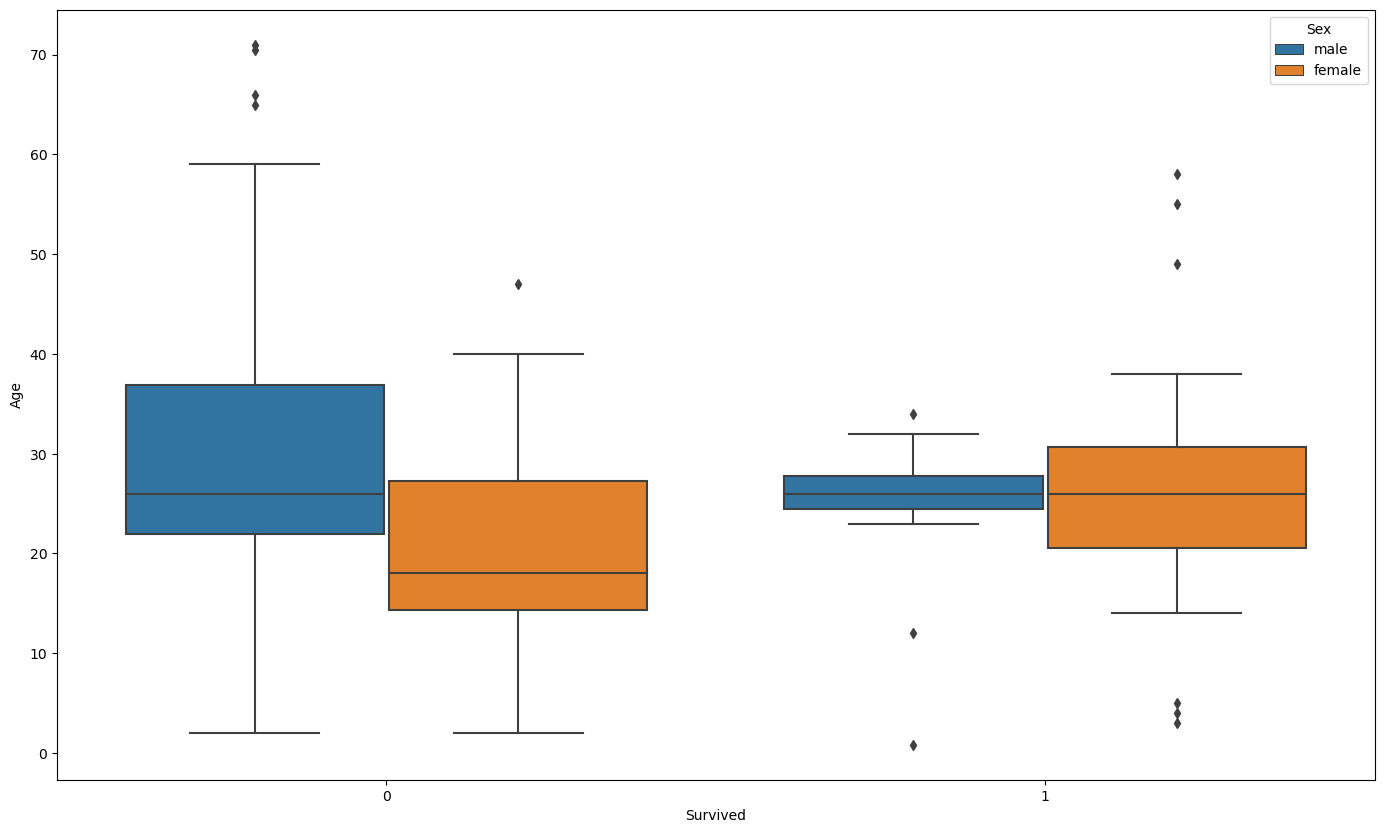

In [9]:
plt.figure(figsize = (17,10))
sns.boxplot(y = df['Age'] , x = df['Survived'] , hue = df['Sex'])


- Nữ sống sót nhiều hơn nam:

- Cột Survived = 1: Hộp màu cam (nữ) cao hơn nhiều.

- Nam sống sót có tuổi tập trung hẹp (~25-30), nữ sống sót tuổi trải dài hơn.

- Nam giới tử vong nhiều hơn:

- Cột Survived = 0: Hộp xanh (nam) lớn và nhiều outlier.

- Nhiều nam tử vong ở độ tuổi 20-40.

- Trẻ em và phụ nữ dễ sống sót hơn:

- Nữ sống sót nhiều ở mọi độ tuổi (thể hiện bằng hộp màu cam bên Survived = 1).

- Nam chỉ sống sót tập trung vào 1 nhóm nhỏ tuổi (hẹp).

- Phụ nữ có tỉ lệ sống sót cao hơn nam (đúng với chính sách Titanic: "Ladies and children first").

 - Nam giới, dù ở độ tuổi nào cũng dễ tử vong hơn.

 - Tuổi có ảnh hưởng nhẹ đến tỉ lệ sống sót, nhưng yếu tố giới tính rõ rệt hơn.

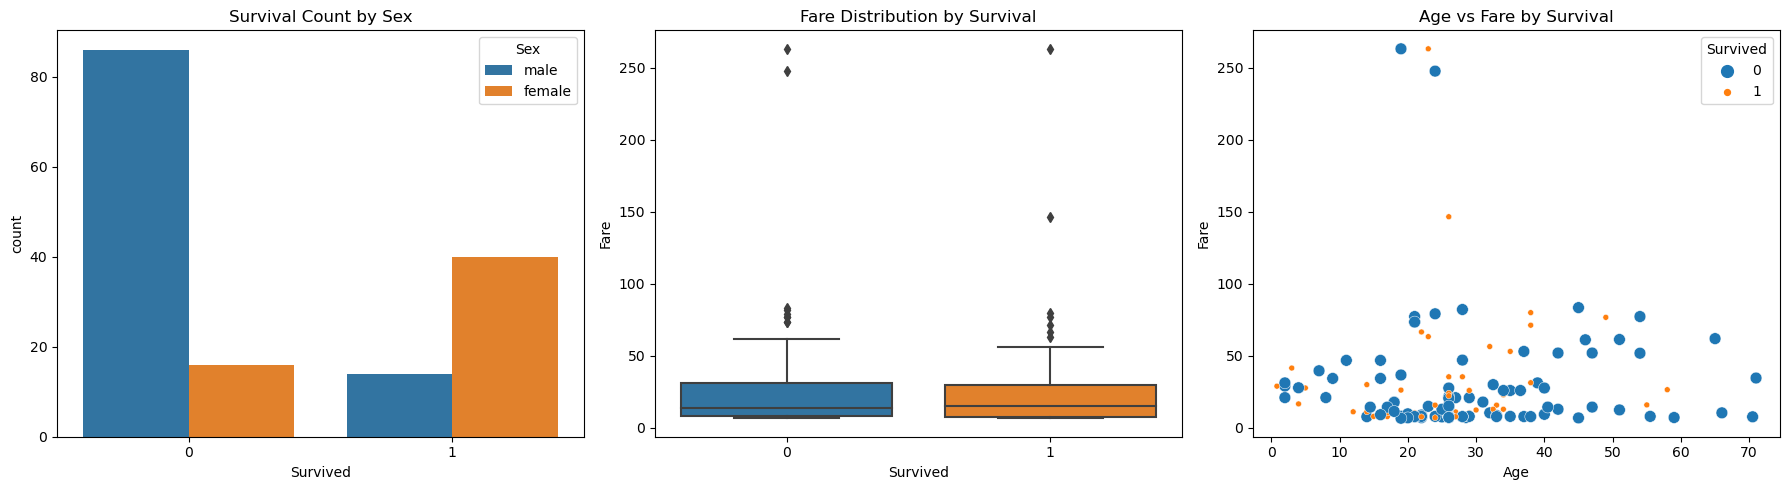

In [10]:
# Thiết lập bố cục cho 3 biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Survived', hue='Sex', data=df, ax=axes[0])
axes[0].set_title('Survival Count by Sex')

sns.boxplot(x='Survived', y='Fare', data=df, ax=axes[1])
axes[1].set_title('Fare Distribution by Survival')

sns.scatterplot(x='Age', y='Fare', hue='Survived', size='Survived', data=df, ax=axes[2])
axes[2].set_title('Age vs Fare by Survival')

plt.tight_layout()
plt.show()

- Giá vé không có sự khác biệt quá lớn giữa hai nhóm, nhưng người sống sót có xu hướng trả giá vé cao hơn một chút. Điều này có thể liên quan đến việc những người trả giá vé cao hơn thuộc lớp vé cao hơn (Pclass thấp hơn), vốn có khả năng sống sót cao hơn. Tuy nhiên, ảnh hưởng của giá vé không quá rõ ràng.

In [11]:
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_total
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2


In [12]:
X = df.drop('Survived' , axis =1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
standard_cols =['Age' , 'Fare']
categorical_cols = ['Sex', 'Embarked']
prep = PreProcessing(sds_cols=standard_cols, ohe_cols=categorical_cols)
param_grid = {'model__C': [0.1, 1.0, 10.0]}
model = SklearnModel(
    model=LogisticRegression(max_iter=1000),
    preprocessing=prep,
    param_grid=param_grid
)
labels = ['Died', 'Survived']

# 3. Thiết lập MLflow
mlflow.set_tracking_uri(uri="http://localhost:5000") 
mlflow.set_experiment("Titanic Experiment")

# 4. Huấn luyện và log
with mlflow.start_run(run_name="Logistic Regression"):
    model.fit(X_train, y_train)
    result = model.evaluate(X_test, y_test)

    # Log params
    if hasattr(model.pipeline, "best_params_"):
        mlflow.log_params(model.pipeline.best_params_)
    else:
        mlflow.log_params(model.model.get_params())

    # Log metrics
    mlflow.log_metric("accuracy", result["accuracy"])
    with open("classification_report.txt", "w") as f:
        f.write(str(result["classification_report"]))
    mlflow.log_artifact("classification_report.txt")

    # Log confusion matrix ảnh
    cm_path = log_confusion_matrix(result["confusion_matrix"], labels)
    mlflow.log_artifact(cm_path)

    # Log model
    signature = infer_signature(X_train, model.pipeline.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=model.pipeline,
        artifact_path="model",
        signature=signature,
        input_example=X_train[:5],
        registered_model_name="Titanic-LogisticRegression"
    )

2025/05/19 09:55:28 INFO mlflow.tracking.fluent: Experiment with name 'Titanic Experiment' does not exist. Creating a new experiment.


Successfully registered model 'Titanic-LogisticRegression'.
2025/05/19 09:55:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic-LogisticRegression, version 1


🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/139198463418536674/runs/b43aa189a67742e885efd14f640b1f37
🧪 View experiment at: http://localhost:5000/#/experiments/139198463418536674


Created version '1' of model 'Titanic-LogisticRegression'.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Các mô hình và grid tương ứng
models_with_params = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000),
        {'model__C': [0.1, 1.0, 10.0]}
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10]}
    ),
    "SVM": (
        SVC(probability=True),
        {'model__C': [0.1, 1.0], 'model__kernel': ['linear', 'rbf']}
    )
}

# Định nghĩa các cột tiền xử lý
standard_cols = ['Age', 'Fare']
categorical_cols = ['Sex', 'Embarked']
labels = ['Died', 'Survived']

# MLflow config
mlflow.set_tracking_uri(uri="http://localhost:5000") 
mlflow.set_experiment("Titanic Experiment")

# Train từng mô hình
for model_name, (clf, param_grid) in models_with_params.items():
    print(f"\n--- Training: {model_name} ---")

    prep = PreProcessing(sds_cols=standard_cols, ohe_cols=categorical_cols)
    model = SklearnModel(model=clf, preprocessing=prep, param_grid=param_grid)

    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        result = model.evaluate(X_test, y_test)

        # Log parameters
        if hasattr(model.pipeline, "best_params_"):
            mlflow.log_params(model.pipeline.best_params_)
        else:
            mlflow.log_params(model.model.get_params())

        # Log metrics
        mlflow.log_metric("accuracy", result["accuracy"])

        # Log classification report
        with open("classification_report.txt", "w") as f:
            f.write(str(result["classification_report"]))
        mlflow.log_artifact("classification_report.txt")

        # Log confusion matrix
        cm_path = log_confusion_matrix(result["confusion_matrix"], labels)
        mlflow.log_artifact(cm_path)

        # Log model
        signature = infer_signature(X_train, model.pipeline.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model.pipeline,
            artifact_path="model",
            signature=signature,
            input_example=X_train[:5],
            registered_model_name=f"Titanic-{model_name}"
        )



--- Training: LogisticRegression ---


Registered model 'Titanic-LogisticRegression' already exists. Creating a new version of this model...
2025/05/19 09:59:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic-LogisticRegression, version 2
Created version '2' of model 'Titanic-LogisticRegression'.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/139198463418536674/runs/208ea21e3a214580bb6cf5168e5bdb11
🧪 View experiment at: http://localhost:5000/#/experiments/139198463418536674

--- Training: RandomForest ---


Successfully registered model 'Titanic-RandomForest'.
2025/05/19 09:59:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic-RandomForest, version 1
Created version '1' of model 'Titanic-RandomForest'.


🏃 View run RandomForest at: http://localhost:5000/#/experiments/139198463418536674/runs/554e0818f6d247a08e0d0f7d84ba6fc9
🧪 View experiment at: http://localhost:5000/#/experiments/139198463418536674

--- Training: SVM ---


Successfully registered model 'Titanic-SVM'.
2025/05/19 09:59:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic-SVM, version 1


🏃 View run SVM at: http://localhost:5000/#/experiments/139198463418536674/runs/29425553097b404aad56bf021fcfa908
🧪 View experiment at: http://localhost:5000/#/experiments/139198463418536674


Created version '1' of model 'Titanic-SVM'.
